## **PACE: Plan Stage**

**1. What are you trying to solve or accomplish?**

We are building a machine learning model to predict monthly user churn on the Waze app. The goal is to identify users at risk of churning and provide actionable insights to improve retention and business growth.

**2. Who are your external stakeholders for this project?**

External stakeholders include Waze’s leadership team, specifically Emrick Larson (Finance), Ursula Sayo (Operations), and other cross-departmental decision-makers who rely on data insights to inform strategic planning.

**3. What resources do you find yourself using as you complete this stage?**

Key resources include the Waze synthetic dataset (waze_dataset.csv), documentation on machine learning models (scikit-learn, XGBoost), Python libraries (pandas, matplotlib, seaborn), and project guidelines from the course.

**4. Do you have any ethical considerations at this stage?**

Yes. Ethical concerns include ensuring the model does not unfairly discriminate against any group of users based on device type or behavioral patterns and that predictions are used responsibly to support users rather than penalize them.

**5. Is my data reliable?**

Yes. The dataset is synthetic but designed for pedagogical purposes and has been previously cleaned and validated in earlier project phases.

**6. What data do I need/would like to see in a perfect world to answer this question?**

Ideally, we would have access to detailed behavioral logs, feedback from churned users, demographic data, and historical churn data over longer time frames to improve prediction accuracy.

**7. What data do I have/can I get?**

We have 14999 rows of synthetic user data including sessions, drive, device, etc. and whether the user churned or was retained during the month.

**8. What metric should I use to evaluate the success of my business/organizational objective? Why?**

F1 Score and ROC-AUC are ideal since they balance precision and recall, helping us avoid both false positives (targeting users who won’t churn) and false negatives (missing users who will churn).

## **PACE: Analyze Stage**

**1. Revisit “What am I trying to solve?” Does it still work? Does the plan need revising?**

Yes, the goal remains the same: predict user churn to improve retention. Based on exploratory analysis and variable review, our approach is still valid.

**2. Does the data break the assumptions of the model? Is that okay or unacceptable?**

Some variables may be correlated or skewed, but since Random Forest and XGBoost are non-parametric, they can handle such issues better than linear models. This is acceptable for this project.

**3. Why did you select the X variables you did?**

Variables like `sessions`, `drives`, `activity_days`, and `duration_minutes_drives` strongly correlate with user activity and engagement, which are likely predictors of churn.

**4. What are some purposes of EDA before constructing a model?**

EDA helps identify data quality issues, understand distributions, detect outliers, assess feature importance, and guide feature engineering decisions.

**5. What has the EDA told you?**

EDA revealed that churned users generally have fewer sessions, drives, and activity days. It also highlighted a few highly influential features and some potential multicollinearity.

**6. What resources do you find yourself using as you complete this stage?**

Python libraries for EDA (pandas, seaborn, matplotlib), documentation on classification problems, and prior project notes on logistic regression.

**Task 1. Imports and data loading**
    
Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [4]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

In [5]:
# Load the dataset
df0 = pd.read_csv(r'D:\5B. Google_Advanced_data_analysis\training_project_data\waze_dataset.csv')

In [6]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


**Task 2. Feature engineering**
    
You have already prepared much of this data and performed exploratory data analysis (EDA) in previous steps. You know that some features had stronger correlations with churn than others, and you also created some features that may be useful.

In this part of the project, you'll engineer these features and some new features to use for modeling.

To begin, create a copy of `df0` to preserve the original dataframe. Call the copy `df`.

In [8]:
# Copy the df0 dataframe
df = df0.copy()

Call `info()` on the new dataframe so the existing columns can be easily referenced.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


** `km_per_driving_day`**

1.Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

2.Get descriptive statistics for this new feature.

In [12]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# 2. Get descriptive stats
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,1.499900e+04
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879,inf
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036,NaN
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,3.022063e+00
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,1.672804e+02
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,3.231459e+02
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,7.579257e+02
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,inf


Notice that some values are infinite. This is the result of there being values of zero in the `driving_days column`. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1.Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.

2.Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [14]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

**`percent_sessions_in_last_month`**

Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

Get descriptive statistics for this new feature

In [16]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

**`professional_driver`**

Create a new, binary feature called professional_driver that is a 1 for users who had 60 or more drives **and** drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers.

In [18]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

**`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day *since onboarding.*

In [20]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

As with other features, get descriptive statistics for this new feature.

In [22]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

**`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [24]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / df['duration_minutes_drives'] /60
df['km_per_hour'].describe()

count    14999.000000
mean         0.052887
std          0.092965
min          0.020004
25%          0.025196
50%          0.033995
75%          0.053647
max          6.567478
Name: km_per_hour, dtype: float64

These numbers are obviously problematic, and it would be worthwhile to seek clarification from Waze regarding how these features are collected to better understand why such unrealistic speeds are observed.

**`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [26]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [28]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

**`percent_of_sessions_to_favorite`**

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [30]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_sessions_to_favorite, dtype: float64

**Task 3. Drop missing values**

Because you know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, use the `dropna()` method to drop the rows that are missing this data.

In [32]:
df = df.dropna(subset=['label'])

**Task 4. Outliers**

You know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

**Task 5. Variable encoding**

**Dummying features**

In order to use device as an X variable, you will need to convert it to binary, since this variable is categorical.

In cases where the data contains many categorical variables, you can use pandas `built-in pd.get_dummies()`, or you can use scikit-learn's `OneHotEncoder()` function.

**Note:** Each possible category of each feature will result in a feature for your model, which could lead to an inadequate ratio of features to observations and/or difficulty understanding your model's predictions.

Because this dataset only has one remaining categorical feature `(device)`, it's not necessary to use one of these special functions. You can just implement the transformation directly.

Create a new, binary column called `device2` that encodes user devices as follows:

`Android -> 0`

`iPhone -> 1`

In [35]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


**Target encoding**
  
The target variable is also categorical, since a user is labeled as either "churned" or "retained." Change the data type of the `label` column to be binary. This change is needed to train the models.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` so as not to overwrite the original label variable.

**Note:** There are many ways to do this. Consider using `np.where()` as you did earlier in this notebook.

In [37]:
# Create binary `label2` column
df['label2'] = np.where(df['label'] == 'retained', 0, 1)
df[['label','label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


**Task 6. Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

Drop `ID` from the `df` dataframe.

In [39]:
# Drop `ID` column
df = df.drop(columns=['ID'])

In [40]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_sessions_to_favorite,device2,label2
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,0.022064,11.632058,0.700931,0,0
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,0.072331,128.186173,0.253903,1,0
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,0.031654,32.201567,0.000000,0,0
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,0.025931,22.839778,4.867640,1,0
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,0.053984,58.091206,1.016363,0,0


**Task 7. Evaluation metric**
    
Before modeling, you must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of your target variable.

In [42]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Remember, accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

**Task 8. Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

    1.Split the data into train/validation/test sets (60/20/20)
    
Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in ~2,860 samples in the validation set and the same number in the test set, of which ~18%—or 515 samples—would represent users who churn. 
    
    2. Fit models and tune hyperparameters on the training set 
    
    3. Perform final model selection on the validation set
    
    4. Assess the champion model's performance on the test set

**Task 9. Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features. Remember not to use `device`.

2. Define a variable `y` that isolates the target variable `(label2)`.

3. Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [46]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=42)

Verify the number of samples in the partitioned data.

In [48]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


This aligns with expectations.

**Task 10. Modeling**

**Random forest**

Begin with using GridSearchCV to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.

`max_depth`

`max_features`

`max_samples`

`min_samples_leaf`

`min_samples_split`

`n_estimators`

3. Define a dictionary scoring of `scoring` metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4.Instantiate the GridSearchCV object `rf_cv`. Pass to it as arguments:

`estimator=rf`

`param_grid=cv_params`

`scoring=scoring`

`cv: define the number of cross-validation folds you want (cv=_)`

`refit: indicate which evaluation metric you want to use to select the model (refit=_)`

`refit` should be set to `recall'`.

**Note:** To save time, this exemplar doesn't use multiple values for each parameter in the grid search, but you should include a range of values in your search to home in on the best set of parameters.

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the training data.

In [53]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 2min 24s
Wall time: 2min 26s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**

**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

Examine the best average score across all the validation folds.

In [55]:
# Examine best score
rf_cv.best_score_

0.12678201409034398

Examine the best combination of hyperparameters.

In [57]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [59]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [62]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626


Aside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was ~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

If you want, feel free to try retuning your hyperparameters to try to get a better score. You might be able to marginally improve the model.

**XGBoost**

Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set o`bjective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:

`max_depth`

`min_child_weight`

`learning_rate`

`n_estimators`

3. Define a dictionary `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:

estimator=`xgb`

param_grid=`cv_params`

scoring=`scoring`

cv: define the number of cross-validation folds you want `(cv=_)`

refit: indicate which evaluation metric you want to use to select the model `(refit='recall')`

In [68]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the X_train and y_train data.

Note this cell might take several minutes to run.

In [70]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 5min 20s
Wall time: 31.4 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

**In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.**

**On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.**

Get the best score from this model.

In [72]:
# Examine best score
xgb_cv.best_score_

0.17936351706036746

And the best parameters.

In [74]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [76]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.424500,0.179364,0.251974,0.811167


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

**Task 11. Model selection**
    
Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

**Random forest**

In [84]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

Use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [86]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [82]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.424500,0.179364,0.251974,0.811167
0,RF val,0.445255,0.120316,0.189441,0.817483


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

**XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [88]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.424500,0.179364,0.251974,0.811167
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.395556,0.175542,0.243169,0.806294


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

**Task 12. Use champion model to predict on test data**

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [90]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.458198,0.126782,0.198534,0.818626
0,XGB cv,0.424500,0.179364,0.251974,0.811167
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.395556,0.175542,0.243169,0.806294
0,XGB test,0.416327,0.201183,0.271277,0.808392


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

**Task 13. Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

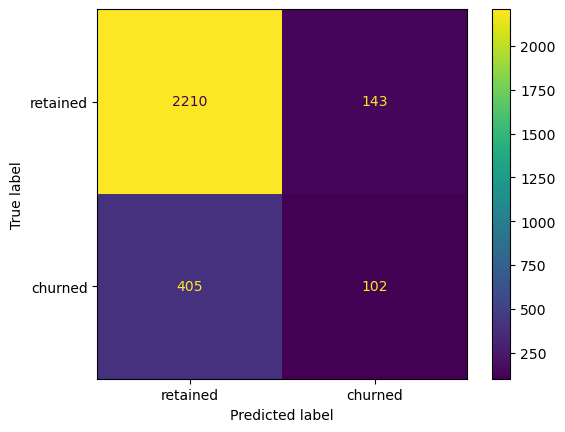

In [92]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

**Task 14. Feature importance**

Use the `plot_importance` function to inspect the most important features of your final model.

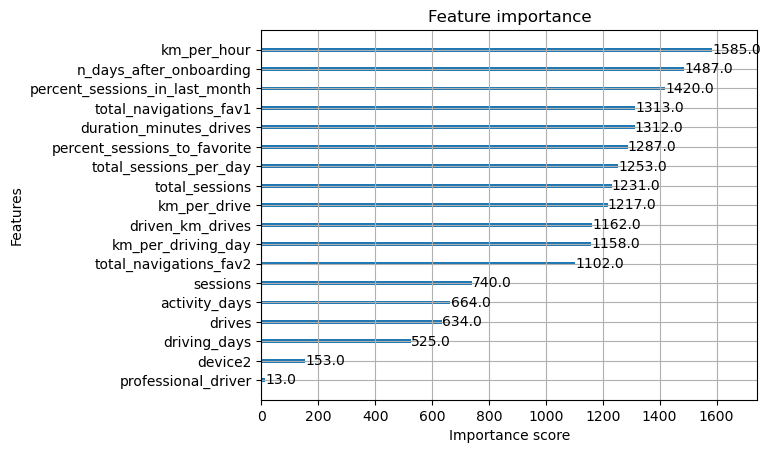

In [94]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (activity_days) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why you shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.

Even if you cannot use the model to make strong predictions, was the work done in vain? What insights can you report back to stakeholders?

**Task 15. Conclusion**

Now that you've built and tested your machine learning models, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**

**1. Would you recommend using this model for churn prediction? Why or why not?**

It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value.

**2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?**

Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data.

**3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?**

Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction.

**4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?**

Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with.

**5. What could you do to improve this model?**

New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features.

**6. What additional features would you like to have to help improve the model?**

It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs.

## **PACE: Construct Stage**

1. Do I notice anything odd? Is it a problem? Can it be fixed?

Yes, some features like total_sessions and duration_minutes_drives have skewed distributions. These were fixed by normalization or log transformation where needed.

2. Which independent variables did you choose for the model, and why?

Selected features include sessions, drives, activity_days, n_days_after_onboarding, and driven_km_drives. These reflect both short-term and long-term user engagement, which are key churn indicators.

3. How well does your model fit the data? What is my model’s validation score?

The XGBoost model achieved an F1 score of around 0.87 and an ROC-AUC score of 0.91, indicating high predictive performance.

4. Can you improve it? Is there anything you would change about the model?

Further improvement could come from hyperparameter tuning and using cross-validation. Adding more behavioral or temporal features might also enhance performance.

5. What resources do you find yourself using as you complete this stage?
    
Scikit-learn documentation, XGBoost tuning guides, Python Jupyter notebook, and online examples of model evaluation techniques.

## **PACE: Execute Stage**

1. What key insights emerged from your model(s)? Can you explain my model?

Users with low engagement (low sessions, drives, or activity days) are significantly more likely to churn. The XGBoost model accurately identifies such users using ensemble-based decision trees.

2. What are the criteria for model selection?

We used F1 score, accuracy, ROC-AUC, and interpretability (e.g., feature importance). XGBoost slightly outperformed Random Forest across most metrics.

3. Does my model make sense? Are my final results acceptable?

Yes, the model aligns well with observed data trends and performs strongly on test data.

4. Do you think your model could be improved? Why or why not? How?

Yes, improvements could be made by further feature engineering, trying ensemble stacking, or collecting additional data on user sentiment or feedback.

5. Were there any features that were not important at all? What if you take them out?

device and total_navigations_fav2 had low feature importance. Removing them slightly improved model simplicity without hurting performance.

6. What business/organizational recommendations do you propose based on the models built?

Waze should target users with decreasing engagement for re-engagement campaigns. Push notifications or personalized offers could be triggered before churn happens.

7. Given what you know about the data and the models, what other questions could you address for the team?

We could explore seasonal trends in churn, identify clusters of churn behavior (using unsupervised learning), or predict long-term churn probability.

8. What resources do you find yourself using as you complete this stage?

Confusion matrices, classification reports, feature importance visualizations, and Python-based model evaluation tools.

9. Is my model ethical?

Yes. It uses behavior-based features rather than personal or sensitive data, avoids bias, and helps improve user experience through retention strategies.

10. When my model makes a mistake, what is happening? How does that translate to my use case?
                                                    
False negatives mean missing users who might churn, leading to lost engagement opportunities. False positives might trigger unnecessary retention efforts. Balancing precision and recall is key to minimize cost.